# Načítání a předpreparace dat

In [145]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import models, regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [127]:
# set seed to ensure reproducibility
random.seed(42)

# Define the data directories
source_dir_bike = "Datasets/Car-Bike-Dataset/Bike"
source_dir_car = "Datasets/Car-Bike-Dataset/Car"

# Define the destination directories
destination_dirs = ["train/Bike", "test/Bike", "validation/Bike", "train/Car", "test/Car", "validation/Car"]

# Make the destination directories if they don't exist
for dir in destination_dirs:
    if not os.path.exists(dir):
        os.makedirs(dir)

# Function to split files
def split_files(source_dir, train_dir, test_dir, validation_dir):
    # Get all file names in source directory
    files = os.listdir(source_dir)
    random.shuffle(files)

    # Get the count for splitting
    train_count = int(0.8 * len(files))
    test_count = int(0.1 * len(files))
    # Remaining files are used for validation

    # Split the files
    train_files = files[:train_count]
    test_files = files[train_count:train_count + test_count]
    validation_files = files[train_count + test_count:]

    # Copy files to destination directories
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), train_dir)
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), test_dir)
    for file in validation_files:
        shutil.copy(os.path.join(source_dir, file), validation_dir)

# Call the function for both bikes and cars
split_files(source_dir_bike, "train/Bike", "test/Bike", "validation/Bike")
split_files(source_dir_car, "train/Car", "test/Car", "validation/Car")


In [128]:
# Define your batch size
batch_size = 10

# Create an ImageDataGenerator object for each set (train, validation, and test)
# We're using the vgg16 preprocess_input function to preprocess our images 
train_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# Use flow_from_directory to generate batches from the train, validation and test directories
train_batches = train_datagen.flow_from_directory(
    directory="train",
    target_size=(64, 64),
    classes=["Bike", "Car"],
    batch_size=batch_size)

validation_batches = validation_datagen.flow_from_directory(
    directory="validation",
    target_size=(64, 64),
    classes=["Bike", "Car"],
    batch_size=batch_size)

test_batches = test_datagen.flow_from_directory(
    directory="test",
    target_size=(64, 64),
    classes=["Bike", "Car"],
    batch_size=batch_size, shuffle = False)


Found 3200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [129]:
images, labels = next(train_batches)

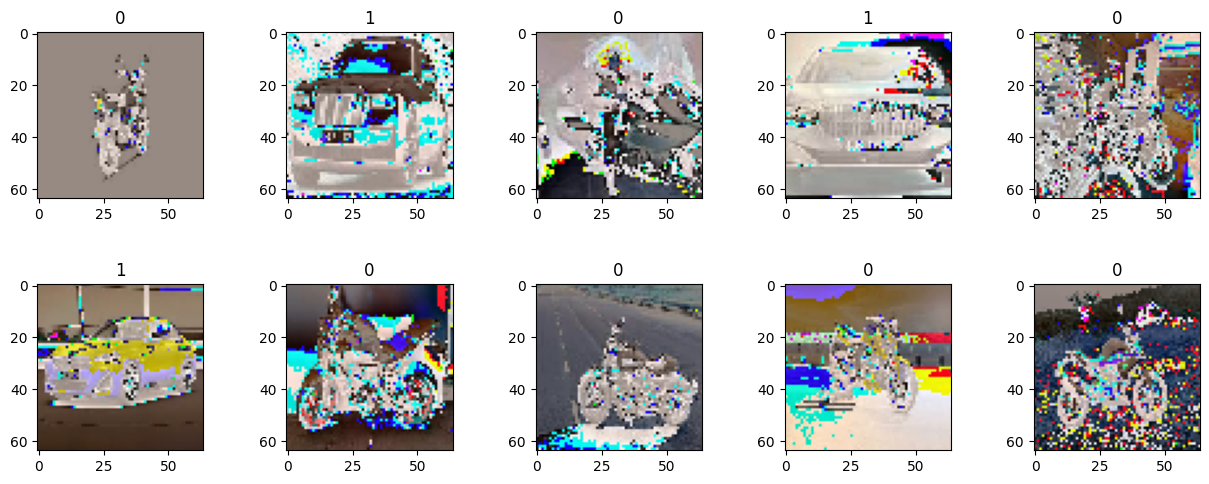

In [130]:
# Define the function
def plot_images(images, labels):
    # VGG16 preprocess input scales the pixel values in the image, this operation inverts that
    images = images.astype(np.uint8)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    for i in np.arange(0, 10):  # Adjust depending on batch size
        axes[i].imshow(images[i])
        axes[i].set_title(labels[i], fontsize=12)
        plt.subplots_adjust(wspace=0.5)

    plt.show()

# Convert one-hot encoded labels to single digit ones
labels_single_digit = np.argmax(labels, axis=1)

# Call the function
plot_images(images, labels_single_digit)


# Vytváření modelů v keras

## Model 1

In [131]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Flatten the tensor output from the convolutional layers
model.add(Flatten())

# Add the dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

# Output layer
model.add(Dense(2, activation='softmax'))

In [132]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 8, 8, 128)      

In [162]:
model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [163]:
history = model.fit(x = train_batches, validation_data = validation_batches, epochs = 5, verbose = 2)

Epoch 1/5


/opt/tljh/user/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


320/320 - 51s - loss: 0.6418 - accuracy: 0.8416 - val_loss: 0.3101 - val_accuracy: 0.9000 - 51s/epoch - 159ms/step
Epoch 2/5
320/320 - 48s - loss: 0.3501 - accuracy: 0.8978 - val_loss: 0.3297 - val_accuracy: 0.9050 - 48s/epoch - 151ms/step
Epoch 3/5
320/320 - 48s - loss: 0.2655 - accuracy: 0.9200 - val_loss: 0.2611 - val_accuracy: 0.9175 - 48s/epoch - 150ms/step
Epoch 4/5
320/320 - 49s - loss: 0.2246 - accuracy: 0.9375 - val_loss: 0.2729 - val_accuracy: 0.9075 - 49s/epoch - 153ms/step
Epoch 5/5
320/320 - 48s - loss: 0.2155 - accuracy: 0.9450 - val_loss: 0.3011 - val_accuracy: 0.9225 - 48s/epoch - 150ms/step


## Model 2

In [146]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(128))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))

In [147]:
model2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                     

In [148]:
model2.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [150]:
history2 = model2.fit(x = train_batches, validation_data = validation_batches, epochs = 8, verbose = 2)

Epoch 1/8


/opt/tljh/user/lib/python3.9/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


320/320 - 56s - loss: 3.0623 - accuracy: 0.7306 - val_loss: 0.4302 - val_accuracy: 0.8600 - 56s/epoch - 174ms/step
Epoch 2/8
320/320 - 54s - loss: 0.4632 - accuracy: 0.8403 - val_loss: 0.2750 - val_accuracy: 0.9000 - 54s/epoch - 170ms/step
Epoch 3/8
320/320 - 54s - loss: 0.4147 - accuracy: 0.8609 - val_loss: 0.8034 - val_accuracy: 0.8100 - 54s/epoch - 170ms/step
Epoch 4/8
320/320 - 53s - loss: 0.3591 - accuracy: 0.8756 - val_loss: 1.8638 - val_accuracy: 0.7375 - 53s/epoch - 167ms/step
Epoch 5/8
320/320 - 53s - loss: 0.3434 - accuracy: 0.8794 - val_loss: 0.2593 - val_accuracy: 0.8800 - 53s/epoch - 165ms/step
Epoch 6/8
320/320 - 55s - loss: 0.3005 - accuracy: 0.8944 - val_loss: 0.4207 - val_accuracy: 0.8825 - 55s/epoch - 171ms/step
Epoch 7/8
320/320 - 54s - loss: 0.3046 - accuracy: 0.8972 - val_loss: 0.2830 - val_accuracy: 0.8975 - 54s/epoch - 169ms/step
Epoch 8/8
320/320 - 55s - loss: 0.2602 - accuracy: 0.9097 - val_loss: 0.3739 - val_accuracy: 0.8950 - 55s/epoch - 172ms/step


# Evaluace

In [135]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [151]:
predictions = model.predict(x = test_batches)
predictions2 = model2.predict(x = test_batches)

40/40 [==============================] - 1s 31ms/step


In [137]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [152]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))
cm2 = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions2, axis = -1))
cm

array([[186,  14],
       [ 20, 180]])

In [153]:
cm2

array([[191,   9],
       [ 22, 178]])

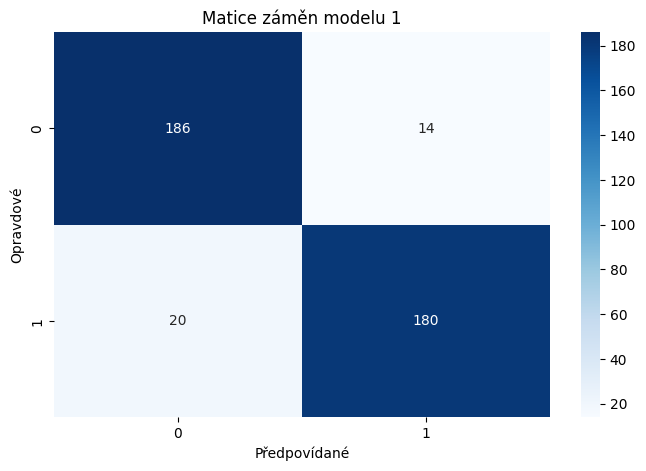

In [182]:
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Předpovídané')
plt.ylabel('Opravdové')
plt.title("Matice záměn modelu 1")
plt.savefig('Matice_záměn_modelu_1.png')
plt.show()


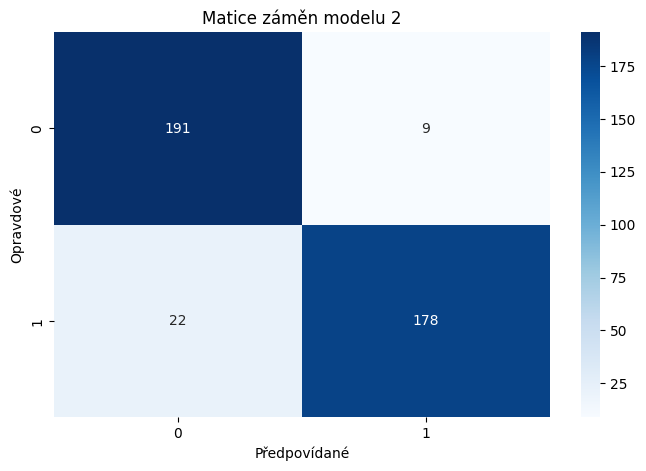

In [183]:
plt.figure(figsize=(8, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Předpovídané')
plt.ylabel('Opravdové')
plt.title("Matice záměn modelu 2")
plt.savefig('Matice_záměn_modelu_2.png')
plt.show()

In [140]:
accuracy = (cm[1][1] + cm[0][0]) /400

In [141]:
accuracy

0.915

In [157]:
accuracy2 = (cm2[1][1] + cm2[0][0]) /400

In [158]:
accuracy2

0.9225

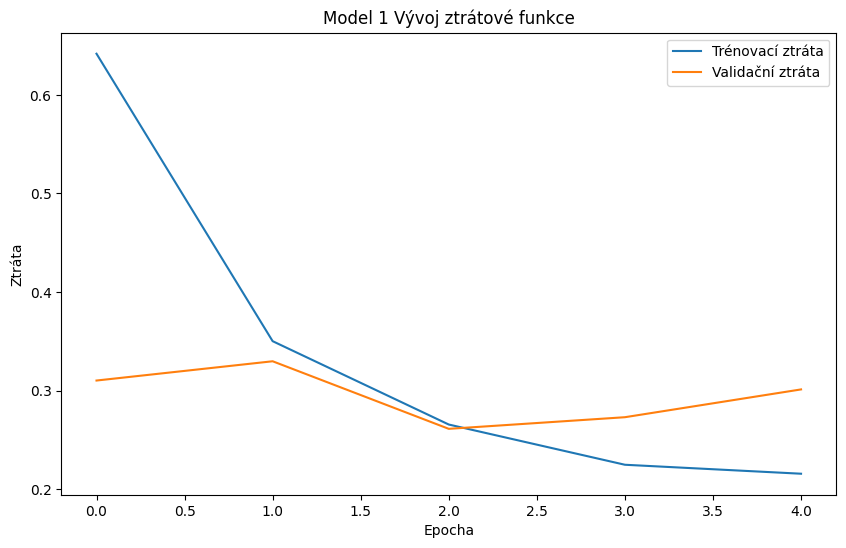

In [184]:
# Plotting training and validation loss
plt.figure(figsize=(10,6)) # Optional: Set the figure size
plt.plot(history.history['loss'], label='Trénovací ztráta')
plt.plot(history.history['val_loss'], label='Validační ztráta')
plt.title('Model 1 Vývoj ztrátové funkce')
plt.ylabel('Ztráta')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.savefig('Vývoj_ztrátové_funkce_model_1.png')
plt.show()


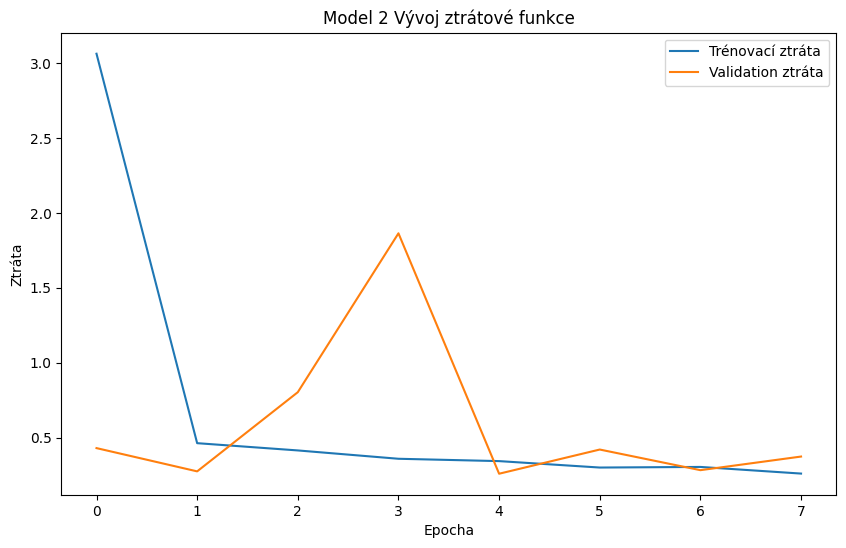

In [185]:
# Plotting training and validation loss
plt.figure(figsize=(10,6)) # Optional: Set the figure size
plt.plot(history2.history['loss'], label='Trénovací ztráta')
plt.plot(history2.history['val_loss'], label='Validation ztráta')
plt.title('Model 2 Vývoj ztrátové funkce')
plt.ylabel('Ztráta')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.savefig('Vývoj_ztrátové_funkce_model_2.png')
plt.show()

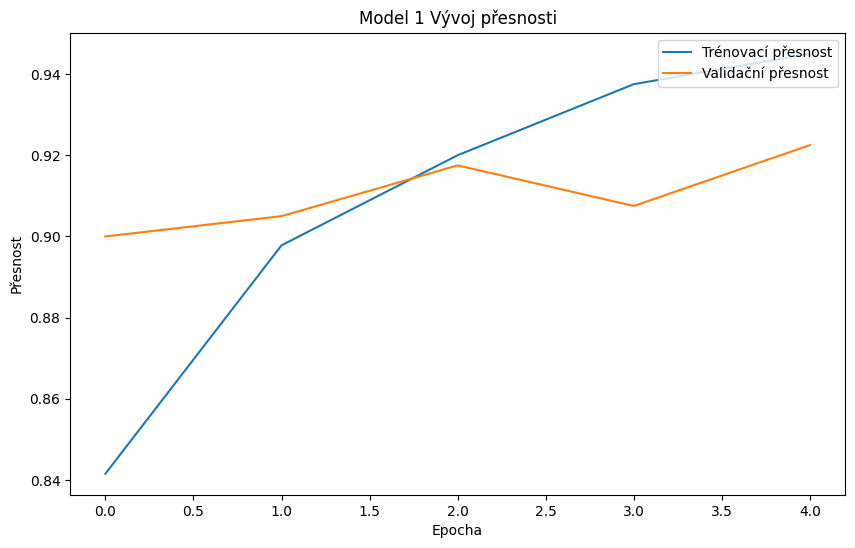

In [186]:
# Plotting training and validation accuracy
plt.figure(figsize=(10,6)) # Optional: Set the figure size
plt.plot(history.history['accuracy'], label='Trénovací přesnost')
plt.plot(history.history['val_accuracy'], label='Validační přesnost')
plt.title('Model 1 Vývoj přesnosti')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.savefig('Vývoj_přesnosti_model_1.png')
plt.show()


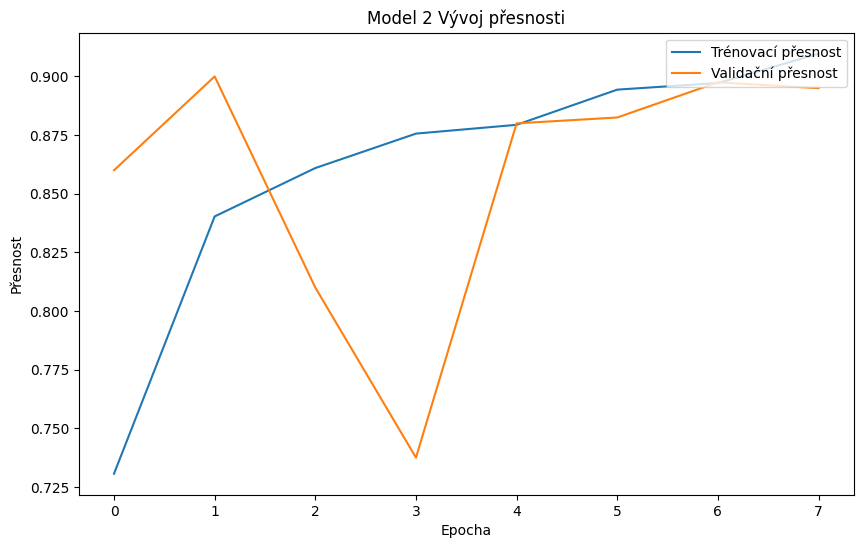

In [187]:
# Plotting training and validation accuracy
plt.figure(figsize=(10,6)) # Optional: Set the figure size
plt.plot(history2.history['accuracy'], label='Trénovací přesnost')
plt.plot(history2.history['val_accuracy'], label='Validační přesnost')
plt.title('Model 2 Vývoj přesnosti')
plt.ylabel('Přesnost')
plt.xlabel('Epocha')
plt.legend(loc='upper right')
plt.savefig('Vývoj_přesnosti_model_2.png')
plt.show()
